In [1]:
import numpy as np
import pandas as pd
import nibabel as nib
import sys
import os
import scipy
import os.path as osp


sys.path.append('..')

from functions.visualization import retinotopic_map_plot, signMap_plot
from deepRetinotopy_TheToolbox.utils.rois import ROI_WangParcelsPlusFovea as roi
from ipywidgets import interact, Dropdown

## Save empirical data as gifti files

In [3]:
def get_giftis(hemisphere, prediction, path_to_freesurfer_dir, path_to_converted_data, mask = False):
    label_primary_visual_areas = ['ROI']
    
    mask_L, mask_R, index_L_mask, index_R_mask = roi(
        label_primary_visual_areas)
    number_cortical_nodes = int(64984)
    number_hemi_nodes = int(number_cortical_nodes / 2)
        
    for sub_id in os.listdir(path_to_freesurfer_dir):
        if hemisphere == 'rh':
            template = nib.load(osp.join(path_to_freesurfer_dir, sub_id + '/surf/' + sub_id + 
                                     '.curvature-midthickness.rh.32k_fs_LR.func.gii'))
            if prediction == 'polarAngle':
                polarAngle = scipy.io.loadmat(osp.join(path_to_converted_data, 
                                                        'cifti_polarAngle_all.mat'))['cifti_polarAngle']
                retinotopicMap_values = torch.tensor(np.reshape(
                    polarAngle['x' + str(sub_id) + 
                                '_fit1_polarangle_msmall'][0][0][number_hemi_nodes:number_cortical_nodes
                                                                ].reshape((number_hemi_nodes)), (-1, 1)
                                                                ),dtype=torch.float)
            elif prediction == 'eccentricity':
                eccentricity = scipy.io.loadmat(osp.join(path_to_converted_data, 
                                                         'cifti_eccentricity_all.mat'))['cifti_eccentricity']
                retinotopicMap_values = torch.tensor(np.reshape(
                    eccentricity['x' + str(sub_id) + 
                                 '_fit1_eccentricity_msmall'][0][0][number_hemi_nodes:number_cortical_nodes
                                                                    ].reshape((number_hemi_nodes)), (-1, 1)
                                                                    ),dtype=torch.float)
            elif prediction == 'pRFsize':
                prfsize = scipy.io.loadmat(osp.join(path_to_converted_data, 
                                                         'cifti_pRFsize_all.mat'))['cifti_pRFsize']
                retinotopicMap_values = torch.tensor(np.reshape(
                    prfsize['x' + str(sub_id) + 
                             '_fit1_receptivefieldsize_msmall'][0][0][number_hemi_nodes:number_cortical_nodes
                                                                    ].reshape((number_hemi_nodes)), (-1, 1)
                                                                    ),dtype=torch.float)
            elif prediction == 'variance_explained':
                variance = scipy.io.loadmat(osp.join(path_to_converted_data, 
                                                         'cifti_R2_all.mat'))['cifti_R2']
                retinotopicMap_values = torch.tensor(np.reshape(
                    variance['x' + str(sub_id) + '_fit1_r2_msmall'][0][0][number_hemi_nodes:number_cortical_nodes
                                                                    ].reshape((number_hemi_nodes)), (-1, 1)
                                                                    ),dtype=torch.float)
            if mask==True:
                retinotopicMap_values[mask_R != 1] = -1
        elif hemisphere == 'lh':
            template = nib.load(osp.join(path_to_freesurfer_dir, sub_id + '/surf/' + sub_id + 
                                     '.curvature-midthickness.lh.32k_fs_LR.func.gii'))
            if prediction == 'polarAngle':
                polarAngle = scipy.io.loadmat(osp.join(path_to_converted_data, 
                                                        'cifti_polarAngle_all.mat'))['cifti_polarAngle']
                retinotopicMap_values = torch.tensor(np.reshape(
                    polarAngle['x' + str(sub_id) + '_fit1_polarangle_msmall'][0][
                        0][0:number_hemi_nodes].reshape((number_hemi_nodes)), (-1, 1)), dtype=torch.float)
                # Transform the values to match the prediction
                sum = retinotopicMap_values < 180
                minus = retinotopicMap_values > 180
                retinotopicMap_values[sum] = retinotopicMap_values[sum] + 180
                retinotopicMap_values[minus] = retinotopicMap_values[minus] - 180
            
            elif prediction == 'eccentricity':
                eccentricity = scipy.io.loadmat(osp.join(path_to_converted_data, 
                                                         'cifti_eccentricity_all.mat'))['cifti_eccentricity']
                retinotopicMap_values = torch.tensor(np.reshape(
                    eccentricity['x' + str(sub_id) + '_fit1_eccentricity_msmall'][
                        0][0][0:number_hemi_nodes].reshape((number_hemi_nodes)), (-1, 1)), dtype=torch.float)
            elif prediction == 'pRFsize':
                prfsize = scipy.io.loadmat(osp.join(path_to_converted_data, 
                                                         'cifti_pRFsize_all.mat'))['cifti_pRFsize']
                retinotopicMap_values = torch.tensor(np.reshape(
                    prfsize['x' + str(sub_id) + '_fit1_receptivefieldsize_msmall'][
                        0][0][0:number_hemi_nodes].reshape((number_hemi_nodes)), (-1, 1)), dtype=torch.float)
            elif prediction == 'variance_explained':
                variance = scipy.io.loadmat(osp.join(path_to_converted_data, 
                                                         'cifti_R2_all.mat'))['cifti_R2']
                retinotopicMap_values = torch.tensor(np.reshape(
                    variance['x' + str(sub_id) + '_fit1_r2_msmall'][
                        0][0][0:number_hemi_nodes].reshape((number_hemi_nodes)), (-1, 1)), dtype=torch.float)
            
            if mask==True:
                retinotopicMap_values[mask_L != 1] = -1

        retinotopicMap_values = np.reshape(retinotopicMap_values, (number_hemi_nodes,1))
        template.agg_data()[:] = np.reshape(retinotopicMap_values, (-1))

        if hemisphere == 'lh':
            if mask==False:
                nib.save(template, path_to_freesurfer_dir + sub_id + '/deepRetinotopy/' + sub_id + '.fs_empirical_' + prediction +
                                        '_lh.func.gii')
            if mask==True:
                nib.save(template, path_to_freesurfer_dir + sub_id + '/deepRetinotopy/' + sub_id + '.fs_empirical_' + prediction +
                                        '_lh_masked.func.gii')
        elif hemisphere == 'rh':
            if mask==False:
                nib.save(template, path_to_freesurfer_dir + sub_id + '/deepRetinotopy/' + sub_id + '.fs_empirical_' + prediction +
                                            '_rh.func.gii')  
            if mask==True:
                nib.save(template, path_to_freesurfer_dir + sub_id + '/deepRetinotopy/' + sub_id + '.fs_empirical_' + prediction +
                                        '_rh_masked.func.gii')
        print('Empirical map has been saved as ' + sub_id + '.fs_empirical_' + prediction + '_' + hemisphere + '.func.gii')
    return 


In [4]:
path_to_freesurfer_dir = '../../deepRetinotopy_TheToolbox/HCP/freesurfer/'
path_to_converted_data = '../../deepRetinotopy_TheToolbox/HCP/raw/converted/'
retinotopic_map = ['polarAngle', 'eccentricity', 'pRFsize']

for hemisphere in ['rh']:
    for prediction in retinotopic_map:
        get_giftis(hemisphere, prediction, path_to_freesurfer_dir, path_to_converted_data, mask = False)
        get_giftis(hemisphere, prediction, path_to_freesurfer_dir, path_to_converted_data, mask = True)

Empirical map has been saved as 100610.fs_empirical_polarAngle_rh.func.gii
Empirical map has been saved as 140117.fs_empirical_polarAngle_rh.func.gii
Empirical map has been saved as 162935.fs_empirical_polarAngle_rh.func.gii
Empirical map has been saved as 197348.fs_empirical_polarAngle_rh.func.gii
Empirical map has been saved as 116726.fs_empirical_polarAngle_rh.func.gii
Empirical map has been saved as 159239.fs_empirical_polarAngle_rh.func.gii
Empirical map has been saved as 572045.fs_empirical_polarAngle_rh.func.gii
Empirical map has been saved as 233326.fs_empirical_polarAngle_rh.func.gii
Empirical map has been saved as 148133.fs_empirical_polarAngle_rh.func.gii
Empirical map has been saved as 187345.fs_empirical_polarAngle_rh.func.gii
Empirical map has been saved as 550439.fs_empirical_polarAngle_rh.func.gii
Empirical map has been saved as 826353.fs_empirical_polarAngle_rh.func.gii
Empirical map has been saved as 352738.fs_empirical_polarAngle_rh.func.gii
Empirical map has been sa

## Visualization of empirical and predicted maps of the dev set

In [2]:
path_to_freesurfer = '../../deepRetinotopy_TheToolbox/HCP/freesurfer/'
path_to_freesurfer = '../predictions_tmp/'
# subject_id= os.listdir(path_to_freesurfer)
subject_id = ['186949', '169747', '826353', '825048', '671855',
                        '751550', '318637', '131722', '137128', '706040'] # dev set
prediction = Dropdown(options = ['empirical',
                                 'model1', 'model2', 'model3', 'model4', 'model5'])
retinotopic_map = ['polarAngle', 'eccentricity', 'pRFsize']
binarize = Dropdown(options = [False, True])
hemisphere = Dropdown(options = ['lh', 'rh'])

@interact(subject_id=subject_id, prediction = prediction, 
          binarize = binarize, retinotopic_map = retinotopic_map,
          hemisphere = hemisphere)
def plot1(subject_id,prediction, binarize, retinotopic_map, hemisphere):
    return retinotopic_map_plot(subject_id, path_to_freesurfer, '../templates',
                                 prediction = prediction, binarize = binarize,
                                 retinotopic_map = retinotopic_map, hemisphere = hemisphere)

interactive(children=(Dropdown(description='subject_id', options=('186949', '169747', '826353', '825048', '671…

## Performance estimation for model selectiong

<Figure size 640x480 with 0 Axes>

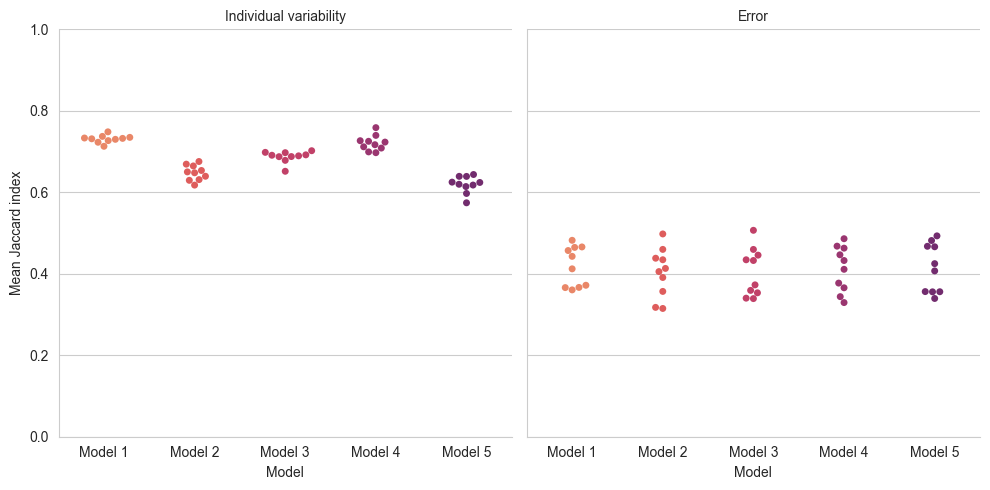

<Figure size 640x480 with 0 Axes>

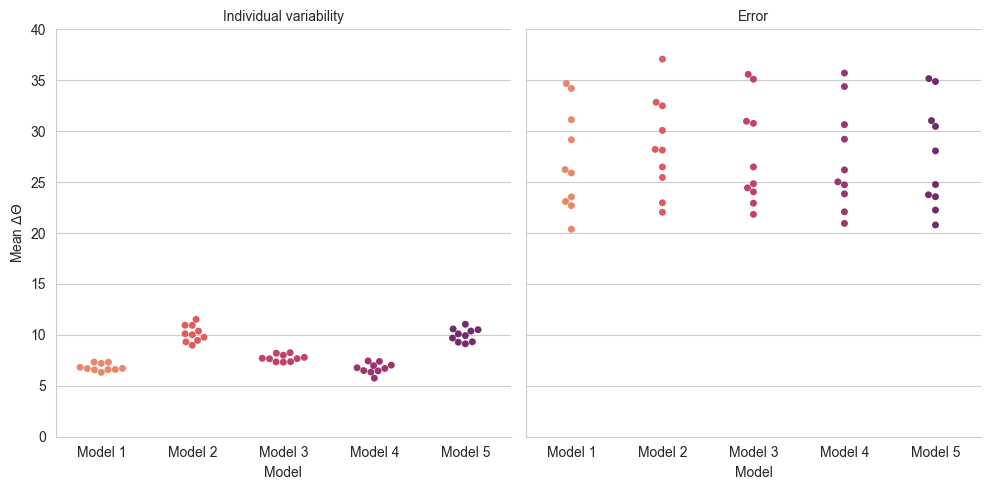

<Figure size 640x480 with 0 Axes>

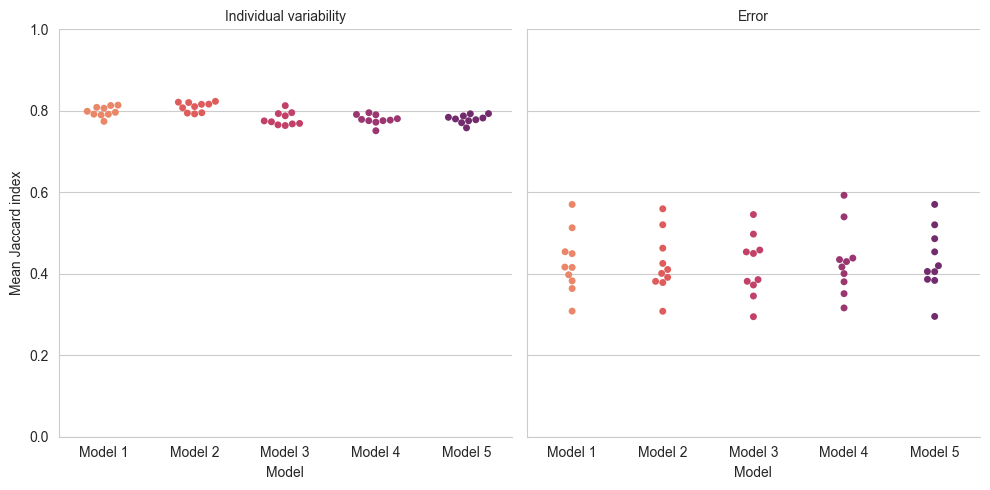

<Figure size 640x480 with 0 Axes>

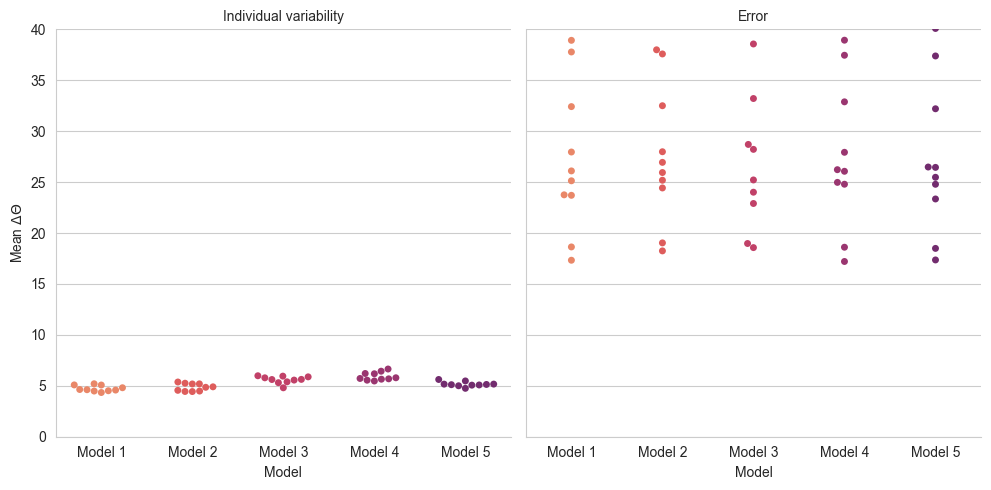

<Figure size 640x480 with 0 Axes>

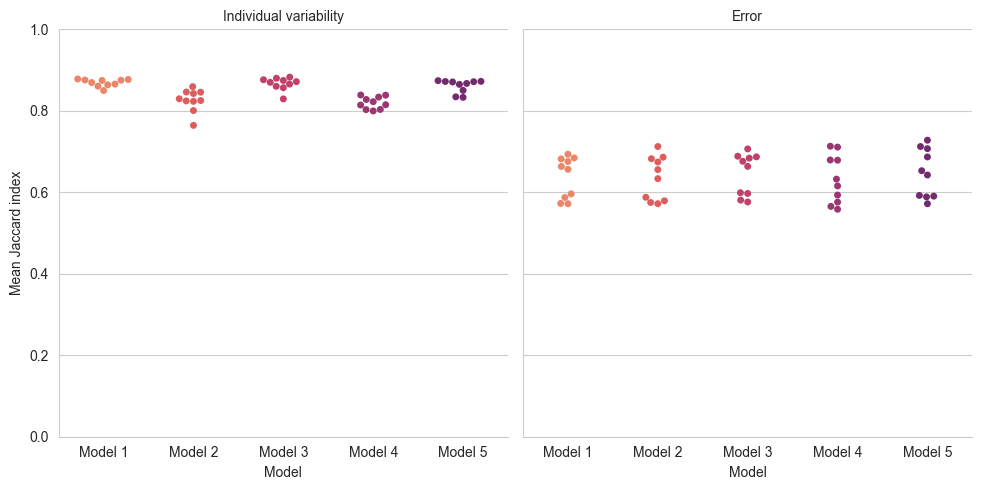

<Figure size 640x480 with 0 Axes>

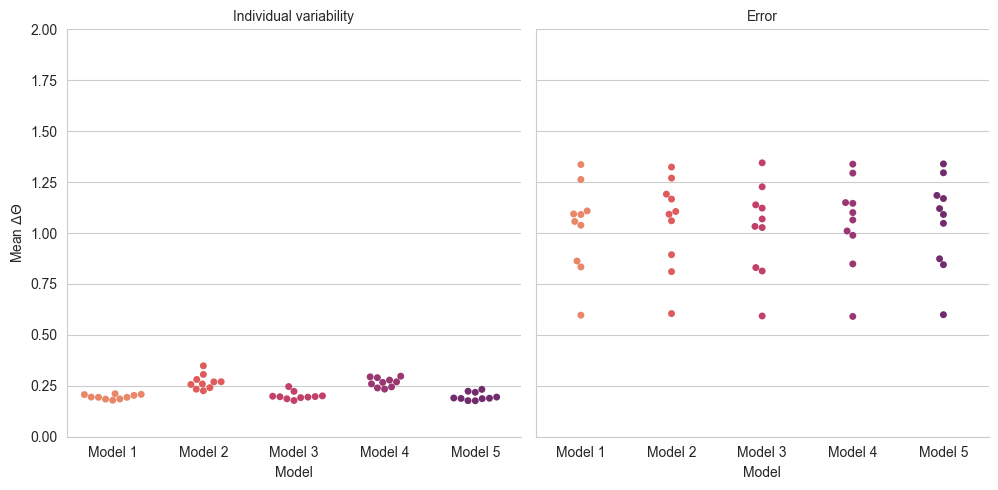

<Figure size 640x480 with 0 Axes>

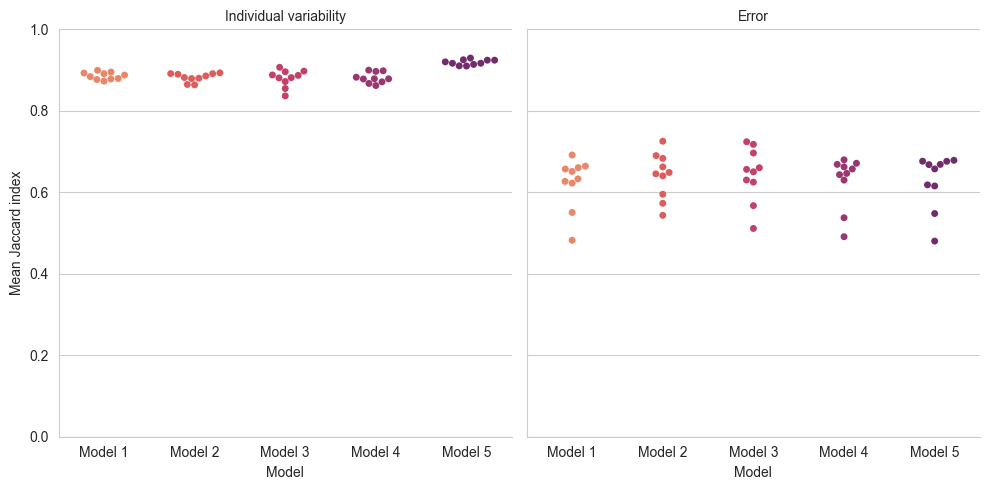

<Figure size 640x480 with 0 Axes>

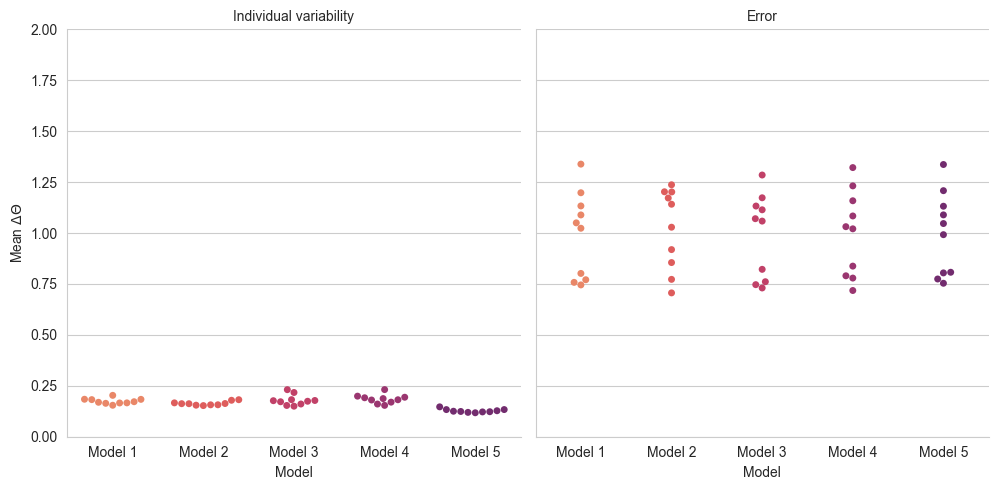

<Figure size 640x480 with 0 Axes>

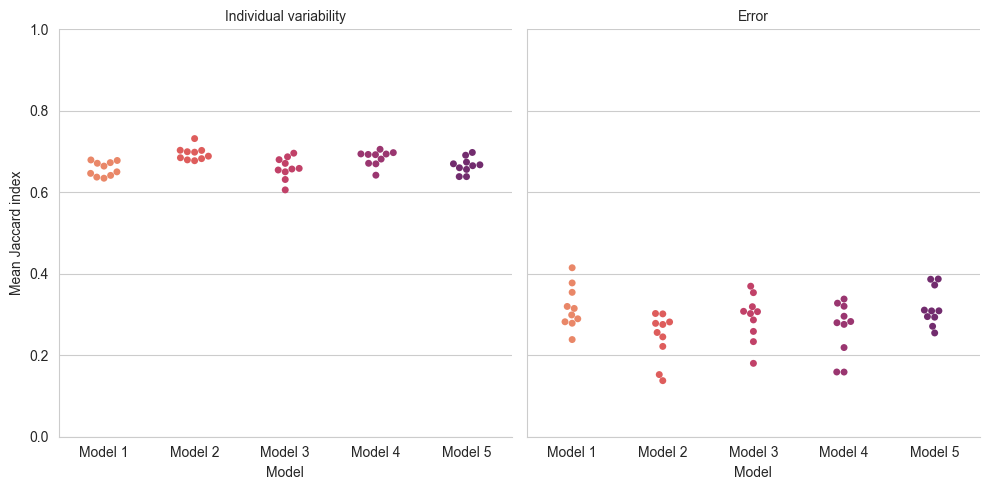

<Figure size 640x480 with 0 Axes>

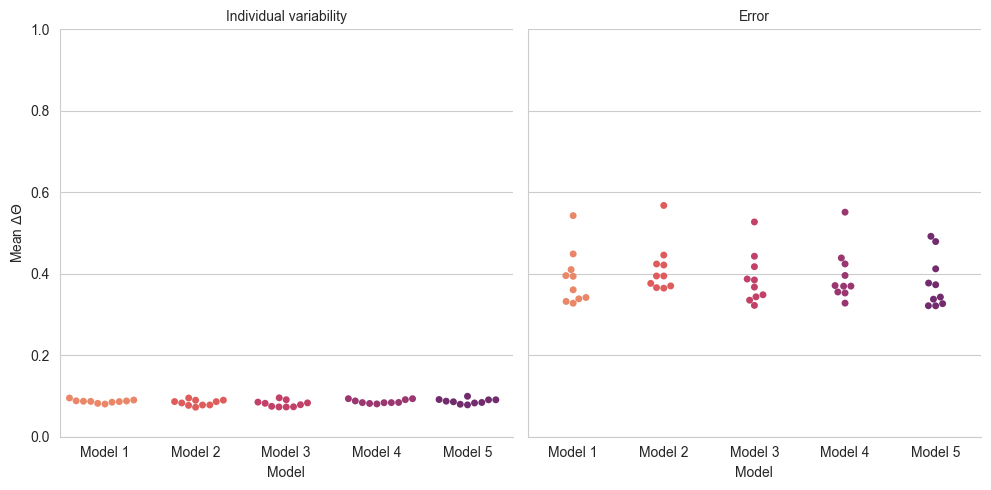

<Figure size 640x480 with 0 Axes>

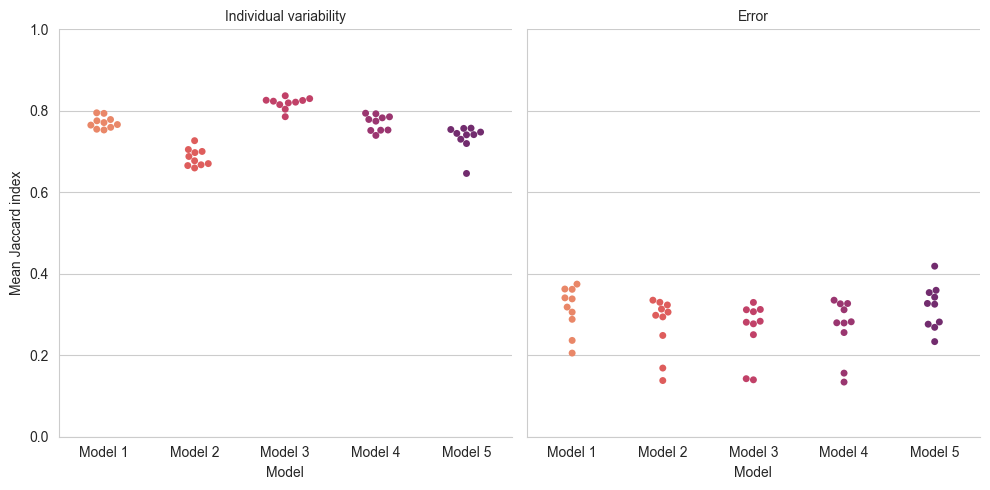

<Figure size 640x480 with 0 Axes>

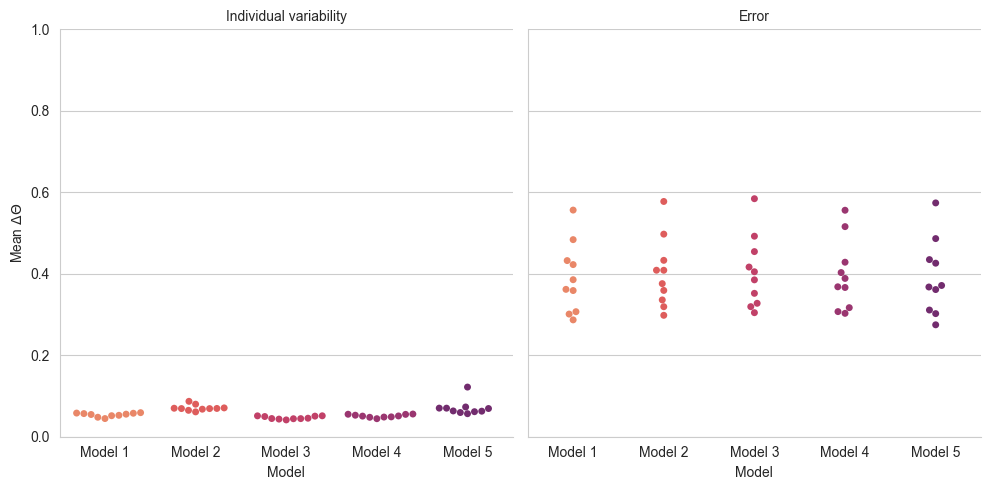

In [3]:
from functions.model_selection import metric_model_selection

retinotopic_maps = ['polarAngle', 'eccentricity', 'pRFsize',]

for retinotopic_map in retinotopic_maps:
    for hemisphere in ['lh', 'rh']:
        for retinotopic_mapping in ['discrete', 'continuous']:
            data = metric_model_selection('../predictions_tmp/', 
                                          retinotopic_map, hemisphere, retinotopic_mapping)
            data.to_csv('../output/' + retinotopic_map + '_' + hemisphere + '_' + retinotopic_mapping + '.xlsx')